In [1]:
import re
import os
import warnings
import pickle
import pandas as pd
import numpy as np
import anndata as ad
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, jensenshannon, cosine
from matplotlib.lines import Line2D
from matplotlib.patches import Patch 

warnings.filterwarnings('ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
%config InlineBackend.figure_format = 'retina'

In [2]:
# Set path
main_path = '/data/qiyu/spatialRegion/'
dir_path = main_path + "data/xenium/xenium_human_non_diseased_lymph_node/"
output_path = main_path + "benchmark/Public_data/Xenium_subsets/"
fig_path = main_path + 'figures/SVG/'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'DejaVu Sans' 

In [3]:
# Subset patches from Xenium lymph node dataset
fov_ranges = [
    range(7,9), 
    range(9,11), 
    range(10,12), 
    range(13,15), 
    range(15,17), 
    range(17,19), 
    range(21,23), 
    range(23,25),  
    range(27,29), 
    range(29,31), 
    range(31,33), 
    range(33,35), 
    range(39,41), 
    range(41,43), 
    range(43,45)
]
fov_names = [f"{r.start}-{r.stop - 1}" for r in fov_ranges]

# Parameters
seed = 42
n_cluster_list = [5, 6, 7]
resolutions = [0.2, 0.3, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
cluster_key_list = [f"cluster_{res:.2f}" for res in resolutions]
marker_genes = ['MS4A1', 'CD19', 'CD79A', 'TRAC', 'IL7R', 'CD3E']

## 1. Benchmarking metrics

Cluster dissimilarity metrics and gene purity were evaluated for each method across 15 representative patches (FOVs) from the Xenium lymph node dataset.

In [11]:
# *Functions for benckmarking metrics*
def compute_cluster_dissimilarity(adata=None, cluster_by_gene=None, cluster_key="leiden"):
    """
    Compute dissimilarity metrics between clusters:
    - Jensen-Shannon Divergence
    - Cosine Distance
    """
    if cluster_by_gene is None and adata is not None:
        if isinstance(adata.X, np.ndarray): 
            df = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names)
        else:  
            df = pd.DataFrame(adata.X.toarray(), index=adata.obs_names, columns=adata.var_names)
        
        cluster_by_gene = df.groupby(adata.obs[cluster_key]).mean()

    if cluster_by_gene is None:
        raise ValueError("Either `adata` or `cluster_by_gene` must be provided.")

    cluster_matrix = cluster_by_gene.to_numpy()
    js_dists = pdist(cluster_matrix, metric=jensenshannon)  
    cosine_dists = pdist(cluster_matrix, metric=cosine)  

    return {
        "Jensen-Shannon Divergence": np.mean(js_dists),
        "Cosine Distance": np.mean(cosine_dists),
    }

### 1.1 `Xenium default segmentation`

In [12]:
cell_adata_path = dir_path + "cell_level_adata_clustered_res1.5.h5ad"
if os.path.exists(cell_adata_path):
    adata_all = sc.read_h5ad(cell_adata_path)
else:
    trans = pd.read_csv(dir_path + "transcripts.csv")
    cells = pd.read_csv(dir_path + "cells.csv.gz", index_col=0)

    valid_cells = cells.index.intersection(trans['cell_id'])   
    trans = trans[trans['cell_id'].isin(valid_cells)]
    cells = cells.loc[valid_cells] 

    print("Creating cell_level_adata_clustered_res1.5.h5ad")
    adata_all = sc.read_10x_h5(dir_path + "cell_feature_matrix.h5")
    adata_all = adata_all[:, ~adata_all.var_names.str.startswith('NegControlProbe')].copy()
    adata_all = adata_all[:, ~adata_all.var_names.str.startswith('BLANK_')].copy()

    sc.pp.normalize_total(adata_all, target_sum=1e6)
    sc.pp.log1p(adata_all)
    sc.tl.pca(adata_all, svd_solver='arpack', n_comps=50)

    coordinates = cells.loc[adata_all.obs_names.intersection(cells.index), ["x_centroid", "y_centroid"]].values
    adata_all = adata_all[adata_all.obs_names.intersection(cells.index), :].copy()

    y_min, y_max = coordinates[:, 1].min(), coordinates[:, 1].max()
    coordinates[:, 1] = y_max - (coordinates[:, 1] - y_min)
    adata_all.obsm['X_spatial'] = coordinates
    sc.pp.neighbors(adata_all, use_rep='X_pca', random_state=seed)
    sc.tl.umap(adata_all)
    sc.tl.leiden(adata_all, resolution=1.5, random_state=seed)
    
    adata_all.write_h5ad(cell_adata_path)

In [13]:
cellular_results = []
gene_purity_results = []

for fov_name in fov_names:
    df_save_name = f"{output_path}{fov_name}/Xenium/cellular_leiden_clusters.csv"
    cluster_df = pd.read_csv(df_save_name, index_col=0)
    adata = adata_all[adata_all.obs_names.isin(cluster_df.index), :].copy()
    expr_matrix = adata.to_df().copy()
    total_gene_expr_dict = expr_matrix[marker_genes].sum()
    
    for cluster_key in cluster_key_list:
        if cluster_key not in cluster_df.columns:
            continue
        adata.obs[cluster_key] = cluster_df[cluster_key]
        num_clusters = adata.obs[cluster_key].nunique()

        # clustering accuracy
        dissimilarity_scores = compute_cluster_dissimilarity(adata, cluster_key=cluster_key)
        for metric, value in dissimilarity_scores.items():
            cellular_results.append({
                "FOV": fov_name,
                "Cluster_Key": cluster_key,
                "Metric": metric,
                "Dissimilarity_Score": value,
                "Num_Clusters": num_clusters,
                "Model": "Xenium"
            })
        
        # gene purity
        for gene in marker_genes:
            if gene not in expr_matrix.columns:
                continue  
            total_gene_expr = total_gene_expr_dict[gene]
            cluster_info = adata.obs[cluster_key]
            for cluster in cluster_info.unique():
                cluster_cells = cluster_info == cluster
                cluster_gene_expr = expr_matrix.loc[cluster_cells, gene].sum()
                gene_purity = cluster_gene_expr / total_gene_expr if total_gene_expr > 0 else 0
                gene_purity_results.append({
                    "FOV": fov_name,
                    "Cluster_Key": cluster_key,
                    "Gene": gene,
                    "Num_Clusters": num_clusters,
                    "Cluster_Gene_Expr": cluster_gene_expr,
                    "Total_Gene_Expr": total_gene_expr,
                    "Gene_Purity": gene_purity,
                    "Model": "Xenium"
                })

cellular_results = pd.DataFrame(cellular_results)
cellular_gene_purity_df = pd.DataFrame(gene_purity_results)

### 1.2 `Cellpose`

In [14]:
cellpose_results = []
cellpose_gene_purity_results = []

for fov_name in fov_names:
    adata_path = f"{output_path}/{fov_name}/Cellpose_cyto3_50/adata.h5ad"
    adata = sc.read_h5ad(adata_path)
    expr_matrix = adata.to_df()
    total_gene_expr_dict = expr_matrix[marker_genes].sum()
    
    for cluster_key in cluster_key_list:
        if cluster_key not in adata.obs.columns:
            continue
        cluster_info = adata.obs[cluster_key]
        dissimilarity_scores = compute_cluster_dissimilarity(adata, cluster_key=cluster_key)
        num_clusters = cluster_info.nunique()
        
        # cluster dissimilarity
        for metric, value in dissimilarity_scores.items():
            cellpose_results.append({
                "FOV": fov_name,
                "Cluster_Key": cluster_key,
                "Metric": metric,
                "Dissimilarity_Score": value,
                "Num_Clusters": num_clusters,
                "Model": "Cellpose"
            })
        
        # gene purity
        for gene in marker_genes:
            if gene not in expr_matrix.columns:
                continue  
            
            total_gene_expr = total_gene_expr_dict[gene]
            for cluster in cluster_info.unique():
                cluster_cells = cluster_info == cluster
                cluster_gene_expr = expr_matrix.loc[cluster_cells, gene].sum()
                gene_purity = cluster_gene_expr / total_gene_expr if total_gene_expr > 0 else 0
                cellpose_gene_purity_results.append({
                    "FOV": fov_name,
                    "Cluster_Key": cluster_key,
                    "Gene": gene,
                    "Num_Clusters": num_clusters,
                    "Cluster_Gene_Expr": cluster_gene_expr,
                    "Total_Gene_Expr": total_gene_expr,
                    "Gene_Purity": gene_purity,
                    "Model": "Cellpose"
                })

cellpose_results = pd.DataFrame(cellpose_results)
cellpose_gene_purity_df = pd.DataFrame(cellpose_gene_purity_results)

### 1.3.1 `Glimmer` (Bin-level)

In [ ]:
binned_results = []
gene_purity_results = []

for fov_name in fov_names:
    adata_path = f"{output_path}/{fov_name}/Glimmer/adata.h5ad"
    adata = sc.read_h5ad(adata_path)
    expr_matrix = adata.to_df()
    total_gene_expr_dict = expr_matrix[marker_genes].sum()
    
    for cluster_key in cluster_key_list:
        if cluster_key not in adata.obs.columns:
            continue
        cluster_info = adata.obs[cluster_key]
        dissimilarity_scores = compute_cluster_dissimilarity(adata, cluster_key=cluster_key)
        num_clusters = cluster_info.nunique()
        
        # cluster dissimilarity
        for metric, value in dissimilarity_scores.items():
            binned_results.append({
                "FOV": fov_name,
                "Cluster_Key": cluster_key,
                "Metric": metric,
                "Dissimilarity_Score": value,
                "Num_Clusters": num_clusters,
                "Model": "Glimmer (Bin)"
            })
        
        # gene purity
        for gene in marker_genes:
            if gene not in expr_matrix.columns:
                continue  
            
            total_gene_expr = total_gene_expr_dict[gene]
            for cluster in cluster_info.unique():
                cluster_cells = cluster_info == cluster
                cluster_gene_expr = expr_matrix.loc[cluster_cells, gene].sum()
                gene_purity = cluster_gene_expr / total_gene_expr if total_gene_expr > 0 else 0
                gene_purity_results.append({
                    "FOV": fov_name,
                    "Cluster_Key": cluster_key,
                    "Gene": gene,
                    "Num_Clusters": num_clusters,
                    "Cluster_Gene_Expr": cluster_gene_expr,
                    "Total_Gene_Expr": total_gene_expr,
                    "Gene_Purity": gene_purity,
                    "Model": "Glimmer (Bin)"
                })

binned_results = pd.DataFrame(binned_results)
gene_purity_df = pd.DataFrame(gene_purity_results)

### 1.3.2 `Glimmer` (Cell-level)

In [18]:
binned_segmentation_results = []
gene_purity_segmentation_results = []

for fov_name in fov_names:
    with open(f"{output_path}{fov_name}/Glimmer/cluster_gex_1.pkl", 'rb') as f:
        res_cluster_gex_list = pickle.load(f)

    for i in range(len(res_cluster_gex_list)):
        res_cluster_gex = res_cluster_gex_list[i]
        cluster_key = f"cluster_{resolutions[i]:.2f}"
        n_cluster = res_cluster_gex.shape[0]

        # cluster dissimilarity
        dissimilarity_scores = compute_cluster_dissimilarity(cluster_by_gene = res_cluster_gex)
        for metric, value in dissimilarity_scores.items():
            binned_segmentation_results.append({
                "FOV": fov_name,
                "Cluster_Key": cluster_key,
                "Metric": metric,
                "Dissimilarity_Score": value,
                "Num_Clusters": n_cluster,
                "Model": "Glimmer (Cell)"
            })

        # gene purity
        total_gene_expr_dict = res_cluster_gex[marker_genes].sum()
        for gene in marker_genes:
            if gene not in res_cluster_gex.columns:
                continue  

            total_gene_expr = total_gene_expr_dict[gene]
            for cluster in res_cluster_gex.index:
                cluster_gene_expr = res_cluster_gex.loc[cluster, gene]
                gene_purity = cluster_gene_expr / total_gene_expr if total_gene_expr > 0 else 0
                gene_purity_segmentation_results.append({
                    "FOV": fov_name,
                    "Cluster_Key": cluster_key,
                    "Gene": gene,
                    "Num_Clusters": n_cluster,
                    "Cluster_Gene_Expr": cluster_gene_expr,
                    "Total_Gene_Expr": total_gene_expr,
                    "Gene_Purity": gene_purity,
                    "Model": "Glimmer (Cell)"
                }) 

binned_segmentation_results = pd.DataFrame(binned_segmentation_results)
gene_purity_segmentation_df = pd.DataFrame(gene_purity_segmentation_results)

### 1.4 `FICTURE`

In [19]:
ficture_results = []
ficture_gene_purity = []

for fov_name in fov_names:
    analysis_path = output_path + f"{fov_name}/Ficture/analysis/"
    folders = [f for f in os.listdir(analysis_path) if os.path.isdir(os.path.join(analysis_path, f))]
    for n_cluster in n_cluster_list:
        matched_folder = [folder for folder in folders if re.match(rf"^nF{n_cluster}.d_*", folder)][0]
        res_hexagon_gex = pd.read_csv(f"{analysis_path}/{matched_folder}/{matched_folder}.posterior.count.tsv.gz", 
                                      sep='\t', index_col=0).T

        # cluster dissimilarity
        dissimilarity_scores = compute_cluster_dissimilarity(cluster_by_gene = res_hexagon_gex)
        for metric, value in dissimilarity_scores.items():
            ficture_results.append({
                "FOV": fov_name,
                "Cluster_Key": f"n_cluster{n_cluster}",
                "Metric": metric,
                "Dissimilarity_Score": value,
                "Num_Clusters": n_cluster,
                "Model": "FICTURE (Hexagon)"
            })

        # gene purity
        total_gene_expr_dict = res_hexagon_gex[marker_genes].sum()
        for gene in marker_genes:
            if gene not in res_hexagon_gex.columns:
                continue  

            total_gene_expr = total_gene_expr_dict[gene]
            for cluster in res_hexagon_gex.index:
                cluster_gene_expr = res_hexagon_gex.loc[cluster, gene]
                gene_purity = cluster_gene_expr / total_gene_expr if total_gene_expr > 0 else 0
                ficture_gene_purity.append({
                    "FOV": fov_name,
                    "Cluster_Key": f"n_cluster{n_cluster}",
                    "Gene": gene,
                    "Num_Clusters": n_cluster,
                    "Cluster_Gene_Expr": cluster_gene_expr,
                    "Total_Gene_Expr": total_gene_expr,
                    "Gene_Purity": gene_purity,
                    "Model": "FICTURE (Hexagon)"
                })

ficture_results = pd.DataFrame(ficture_results)
ficture_gene_purity_df = pd.DataFrame(ficture_gene_purity)

### 1.5 `Baysor(NCV)`

In [20]:
baysor_results = []
baysor_gene_purity = []

for fov_name in fov_names:
    cluster_file_path = f"{output_path}{fov_name}/Baysor/baysor_segfree_adata.csv"
    res_cluster_df = pd.read_csv(cluster_file_path)

    for n_cluster in n_cluster_list:
        col_name = f"cluster_k{n_cluster}"
        res_cluster_gex = res_cluster_df[[col_name, 'gene', 'Count']].pivot_table(
            index=col_name, columns="gene", values="Count", aggfunc="sum", fill_value=0)

        # cluster dissimilarity
        dissimilarity_scores = compute_cluster_dissimilarity(cluster_by_gene = res_cluster_gex)
        for metric, value in dissimilarity_scores.items():
            baysor_results.append({
                "FOV": fov_name,
                "Cluster_Key": f"n_cluster{n_cluster}",
                "Metric": metric,
                "Dissimilarity_Score": value,
                "Num_Clusters": n_cluster,
                "Model": "Baysor (NCV)"
            })

        # gene purity
        total_gene_expr_dict = res_cluster_gex[marker_genes].sum()
        for gene in marker_genes:
            if gene not in res_cluster_gex.columns:
                continue  

            total_gene_expr = total_gene_expr_dict[gene]
            for cluster in res_cluster_gex.index:
                cluster_gene_expr = res_cluster_gex.loc[cluster, gene]
                gene_purity = cluster_gene_expr / total_gene_expr if total_gene_expr > 0 else 0
                baysor_gene_purity.append({
                    "FOV": fov_name,
                    "Cluster_Key": f"n_cluster{n_cluster}",
                    "Gene": gene,
                    "Num_Clusters": n_cluster,
                    "Cluster_Gene_Expr": cluster_gene_expr,
                    "Total_Gene_Expr": total_gene_expr,
                    "Gene_Purity": gene_purity,
                    "Model": "Baysor (NCV)"
                })

baysor_results = pd.DataFrame(baysor_results)
baysor_gene_purity_df = pd.DataFrame(baysor_gene_purity)

### 1.6 Plot benchmarking metrics

In [8]:
save_fig = True 
fixed_palette = {
    "Glimmer (Cell)": "#f03b20",
    "Glimmer (Bin)": "#fecc5c",
    "Baysor (NCV)": "#c7e9c0", 
    "Cellpose": "#e7298a",   
    "Xenium": "#abd9e9",   
    "FICTURE (Hexagon)": "#beaed4"
}
fixed_palette = {k: sns.utils.set_hls_values(v, l=0.54) for k, v in fixed_palette.items()}

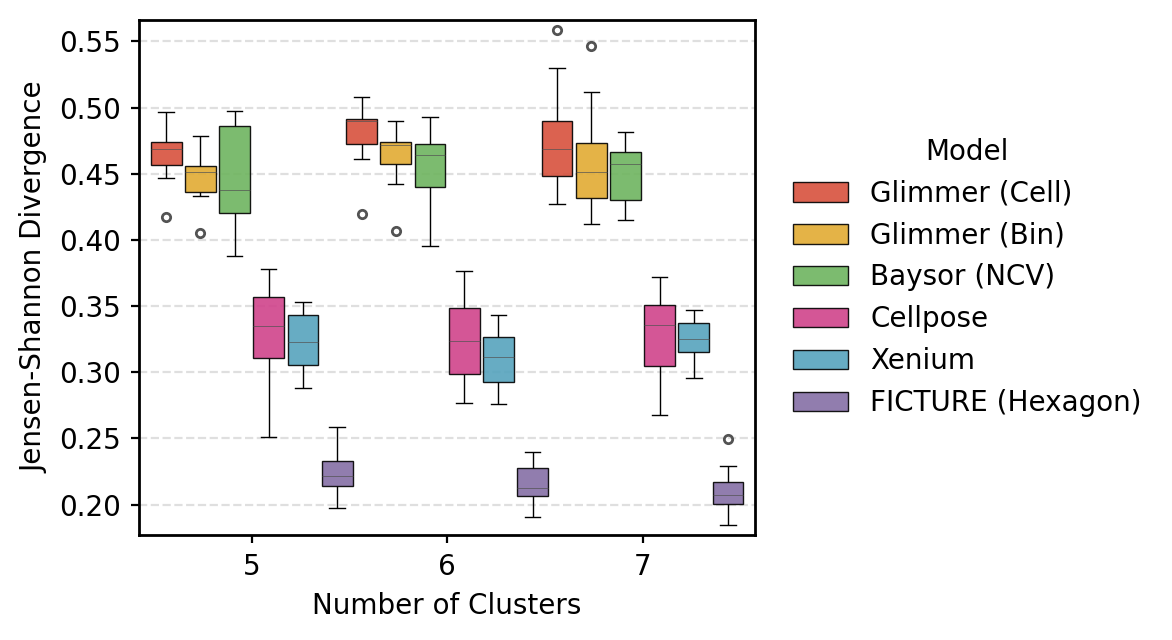

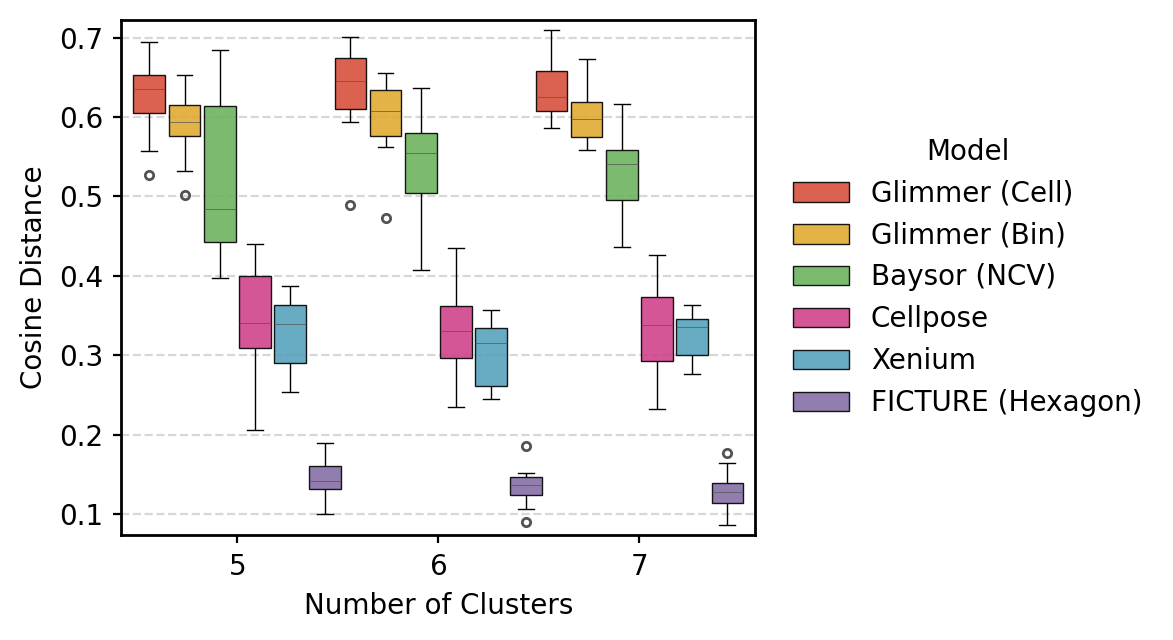

In [23]:
# Cluster dissimilarity
cluster_dissimilarity_file = f"{output_path}/result/cluster_dissimilarity_table.csv"
if os.path.exists(cluster_dissimilarity_file):
    df = pd.read_csv(cluster_dissimilarity_file)
else:
    df = pd.concat([binned_results, 
                    binned_segmentation_results, 
                    ficture_results, 
                    cellular_results, 
                    baysor_results, 
                    cellpose_results])
    df = df[df["Num_Clusters"].isin(n_cluster_list)]
    df["Num_Clusters"] = df["Num_Clusters"].astype(int)
    df = df.groupby(['Model', 'FOV', 'Metric', 'Num_Clusters'])['Dissimilarity_Score'].mean().reset_index()
    df.to_csv(cluster_dissimilarity_file, index=False)

# Split and save Jensen-Shannon Divergence plot
plt.figure(figsize=(6.0, 3.3))
ax = sns.boxplot(
    data=df[df["Metric"] == "Jensen-Shannon Divergence"],
    x="Num_Clusters",
    y="Dissimilarity_Score",
    hue="Model",
    hue_order=fixed_palette.keys(),  
    palette=fixed_palette,        
    width=1.05,
    dodge=True,
    gap=0.1,
    linewidth=0.25,  
    fliersize=3, 
    boxprops=dict(edgecolor="black", linewidth=0.5, alpha=0.9),  
    whiskerprops=dict(color="black", linewidth=0.5), 
    capprops=dict(color="black", linewidth=0.5)
)
ax.margins(x=0.02, y=0.02)
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.0)
ax.tick_params(axis='both', labelsize=10, width=0.8, length=3, bottom=True, left=True) 
plt.title("")
plt.xlabel("Number of Clusters")
plt.ylabel("Jensen-Shannon Divergence")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.legend(title="Model", bbox_to_anchor=(1.02, 0.5), loc="center left", facecolor="white", edgecolor="white")
plt.tight_layout()
if save_fig:
    fig_name = fig_path + 'figure4/fig4_s_benchmarking_js_divergence.svg'
    plt.savefig(fig_name, format="svg", bbox_inches="tight")
plt.show()

# Split and save Cosine Distance plot
plt.figure(figsize=(6.0, 3.3))
ax = sns.boxplot(
    data=df[df["Metric"] == "Cosine Distance"],
    x="Num_Clusters",
    y="Dissimilarity_Score",
    hue="Model",
    hue_order=fixed_palette.keys(),  
    palette=fixed_palette,    
    width=1.05,
    dodge=True,
    gap=0.1,
    linewidth=0.25,  
    fliersize=3, 
    boxprops=dict(edgecolor="black", linewidth=0.5, alpha=0.9),  
    whiskerprops=dict(color="black", linewidth=0.5), 
    capprops=dict(color="black", linewidth=0.5)
)
ax.margins(x=0.02, y=0.02)
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.0)
ax.tick_params(axis='both', labelsize=10, width=0.8, length=3, bottom=True, left=True) 
plt.title("")
plt.xlabel("Number of Clusters")
plt.ylabel("Cosine Distance")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title="Model", bbox_to_anchor=(1.02, 0.5), loc="center left", facecolor="white", edgecolor="white")
plt.tight_layout()
if save_fig:
    fig_name = fig_path + 'figure4/fig4_m_benchmarking_cosine_distance.svg'
    plt.savefig(fig_name, format="svg", bbox_inches="tight")
plt.show() 

In [22]:
from scipy.stats import ks_2samp
from itertools import product

models_1 = ["Glimmer (Cell)", "Glimmer (Bin)"]
models_2 = ["Baysor (NCV)", "Cellpose", "Xenium", "FICTURE (Hexagon)"]

pairwise_results = []
for metric in ["Jensen-Shannon Divergence", "Cosine Distance"]:
    for n_clusters in df["Num_Clusters"].unique():
        for m1, m2 in product(models_1, models_2):
            scores1 = df[
                (df["Metric"] == metric) &
                (df["Num_Clusters"] == n_clusters) &
                (df["Model"] == m1)
            ]["Dissimilarity_Score"].values

            scores2 = df[
                (df["Metric"] == metric) &
                (df["Num_Clusters"] == n_clusters) &
                (df["Model"] == m2)
            ]["Dissimilarity_Score"].values

            if len(scores1) > 0 and len(scores2) > 0:
                ks_stat, p_val = ks_2samp(scores1, scores2)
                pairwise_results.append({
                    "Metric": metric,
                    "Num_Clusters": n_clusters,
                    "Model_1": m1,
                    "Model_2": m2,
                    "KS_statistic": ks_stat,
                    "p_value": p_val,
                    "n1": len(scores1),
                    "n2": len(scores2)
                })

pairwise_df = pd.DataFrame(pairwise_results)
pairwise_df = pairwise_df.sort_values(by=["Metric", "Num_Clusters", "p_value"])
pairwise_df.to_csv(f"{output_path}/result/cluster_dissimilarity_KS_stats.csv", index=False)

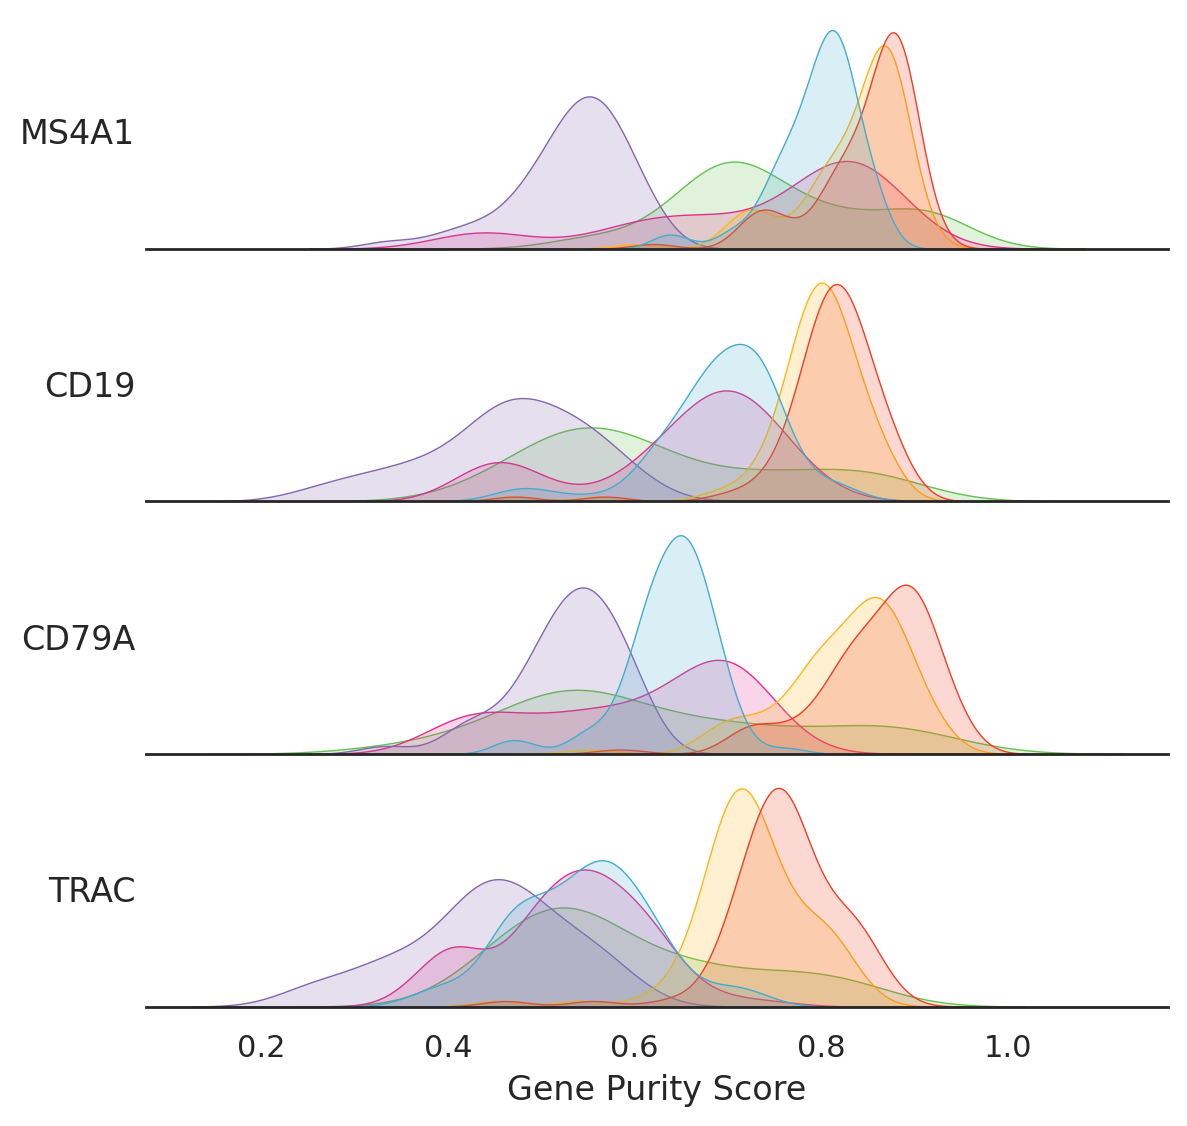

In [24]:
# Density plot of gene purity
gene_purity_file = f"{output_path}/result/gene_purity_table.csv"
if os.path.exists(gene_purity_file):
    df = pd.read_csv(gene_purity_file)
else:
    df = pd.concat([gene_purity_df, 
                    gene_purity_segmentation_df, 
                    cellular_gene_purity_df, 
                    ficture_gene_purity_df, 
                    baysor_gene_purity_df, 
                    cellpose_gene_purity_df])
    df = df[df["Num_Clusters"].astype(int).isin(n_cluster_list)]
    df = df.groupby(['Model', 'FOV', 'Cluster_Key', 'Gene'])['Gene_Purity'].max().reset_index()
    df.to_csv(gene_purity_file, index=False)

# Subset marker genes to show in the final figure
df = df[df['Gene'].isin(['MS4A1', 'CD19', 'TRAC', 'CD3E'])]

# plot
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth': 1}) 
g = sns.FacetGrid(df, row="Gene", hue="Model", aspect=4, height=1.5, palette=fixed_palette, 
                  sharey=False, hue_order=list(fixed_palette.keys()).reverse())
g.map_dataframe(sns.kdeplot, x="Gene_Purity", fill=True, alpha=0.2, linewidth=0.5)
g.set(ylabel="")
for ax, gene in zip(g.axes.flat, marker_genes):
    ax.set_ylabel(gene, fontsize=12, rotation=0, ha="right", va="center")
g.fig.subplots_adjust(hspace=0.1)
g.set_titles("")
g.set(yticks=[], xlabel="Gene Purity Score")
g.despine(left=True)
plt.suptitle('', y=0.99, fontsize=15)
if save_fig:
    fig_name = fig_path + 'figure4/fig4_m_benchmarking_gene_purity.svg'
    plt.savefig(fig_name, format="svg", bbox_inches="tight")
plt.show() 

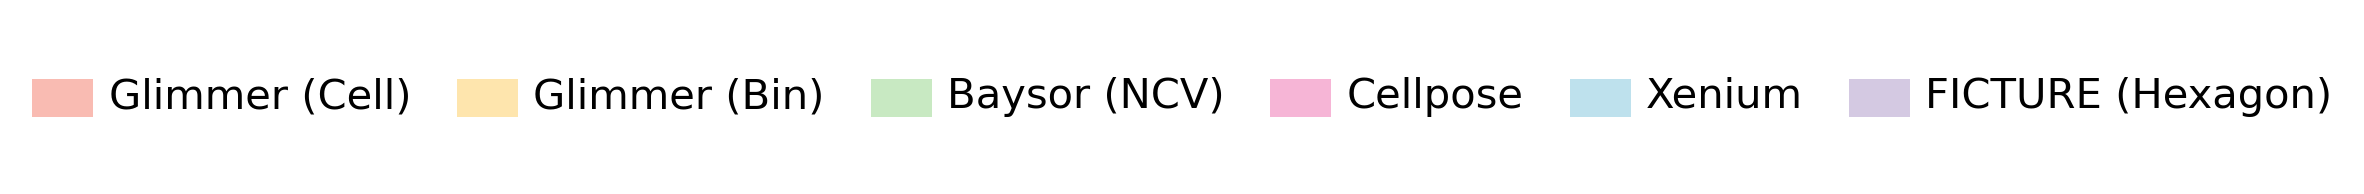

In [25]:
legend_elements = [
    Patch(facecolor=fixed_palette[model], edgecolor='none', alpha=0.35, label=model) 
    for model in fixed_palette.keys()
]
fig_legend = plt.figure(figsize=(5, 1), facecolor='white')
fig_legend.patch.set_facecolor('white')
leg = fig_legend.legend(handles=legend_elements, loc='center', ncol=len(fixed_palette), frameon=True, 
                        facecolor='white', edgecolor='white', handletextpad=0.5, handleheight=1.5, columnspacing=1.5)
plt.setp(leg.get_texts(), color='black', fontsize=15)
plt.axis('off')

if save_fig:
    legend_name = fig_path + 'figure4/fig4_m_benchmarking_gene_purity_legend.svg'
    plt.savefig(legend_name, format="svg", bbox_inches='tight', facecolor='white', edgecolor='none')
plt.show()

In [26]:
models_1 = ["Glimmer (Cell)", "Glimmer (Bin)"]
models_2 = ["Baysor (NCV)", "Cellpose", "Xenium", "FICTURE (Hexagon)"]

results = []
for gene in df['Gene'].unique():
    df_gene = df[df['Gene'] == gene]
    for model1, model2 in product(models_1, models_2):
        group1 = df_gene[df_gene['Model'] == model1]['Gene_Purity']
        group2 = df_gene[df_gene['Model'] == model2]['Gene_Purity']
        if len(group1) > 0 and len(group2) > 0:
            stat, pval = ks_2samp(group1, group2)
            results.append({
                'Gene': gene,
                'Model_1': model1,
                'Model_2': model2,
                'KS_statistic': stat,
                'p_value': pval
            })
df_stats = pd.DataFrame(results)
df_stats.to_csv(f"{output_path}/result/gene_purity_KS_stats.csv", index=False)

### 1.7 Plot cluster distribution from `Glimmer` for all subset FOVs 

In [27]:
# Show our clustering results for all FOVs 
save_fig = False 

cell_type_colors = {
    "B Cells": "#1f77b4",
    "T Cells": "#ff7f0e",
    "Macrophages": "#2ca02c",
    "Endothelial Cells": "#d62728",
    "Plasma Cells": "#9467bd"
}
fov_cluster_info = {
    "7-8": {"cluster_key": "cluster_0.30", "mapping": {"0": "B Cells", "2": "T Cells", "1": "Macrophages", "4": "Plasma Cells", "3": "Endothelial Cells"}},
    "9-10": {"cluster_key": "cluster_0.30", "mapping": {"1": "B Cells", "3": "T Cells", "2": "Macrophages", "0": "Plasma Cells", "4": "Endothelial Cells"}},
    "10-11": {"cluster_key": "cluster_0.30", "mapping": {"1": "B Cells", "0": "T Cells", "2": "Macrophages", "4": "Plasma Cells", "3": "Endothelial Cells"}},
    "13-14": {"cluster_key": "cluster_0.20", "mapping": {"0": "B Cells", "1": "T Cells", "2": "Macrophages", "4": "Plasma Cells", "3": "Endothelial Cells"}},
    "15-16": {"cluster_key": "cluster_0.40", "mapping": {"1": "B Cells", "2": "T Cells", "0": "Macrophages", "4": "Plasma Cells", "3": "Endothelial Cells"}},
    "17-18": {"cluster_key": "cluster_0.40", "mapping": {"3": "B Cells", "0": "T Cells", "1": "Macrophages", "2": "Plasma Cells", "5": "Plasma Cells", "4": "Endothelial Cells"}},
    "21-22": {"cluster_key": "cluster_0.30", "mapping": {"0": "B Cells", "2": "T Cells", "1": "Macrophages", "3": "Plasma Cells", "4": "Endothelial Cells"}},
    "23-24": {"cluster_key": "cluster_0.40", "mapping": {"0": "B Cells", "2": "T Cells", "1": "Macrophages", "4": "Plasma Cells", "3": "Endothelial Cells"}},
    "27-28": {"cluster_key": "cluster_0.30", "mapping": {"1": "B Cells", "4": "T Cells", "2": "Macrophages", "0": "Plasma Cells", "3": "Endothelial Cells"}},
    "29-30": {"cluster_key": "cluster_0.40", "mapping": {"0": "B Cells", "4": "T Cells", "2": "Macrophages", "1": "Plasma Cells", "3": "Endothelial Cells"}},
    "31-32": {"cluster_key": "cluster_0.40", "mapping": {"0": "B Cells", "2": "T Cells", "3": "Macrophages", "4": "Plasma Cells", "1": "Endothelial Cells"}},
    "33-34": {"cluster_key": "cluster_0.40", "mapping": {"2": "B Cells", "0": "T Cells", "4": "T Cells", "1": "Macrophages", "5": "Macrophages", "6": "Plasma Cells", "3": "Endothelial Cells"}},
    "39-40": {"cluster_key": "cluster_0.30", "mapping": {"0": "B Cells", "1": "T Cells", "2": "Macrophages", "4": "Plasma Cells", "3": "Endothelial Cells"}},
    "41-42": {"cluster_key": "cluster_0.50", "mapping": {"1": "B Cells", "3": "T Cells", "0": "Macrophages", "4": "Plasma Cells", "2": "Endothelial Cells"}},
    "43-44": {"cluster_key": "cluster_0.45", "mapping": {"0": "B Cells", "3": "T Cells", "1": "Macrophages", "4": "Plasma Cells", "2": "Endothelial Cells"}}
}

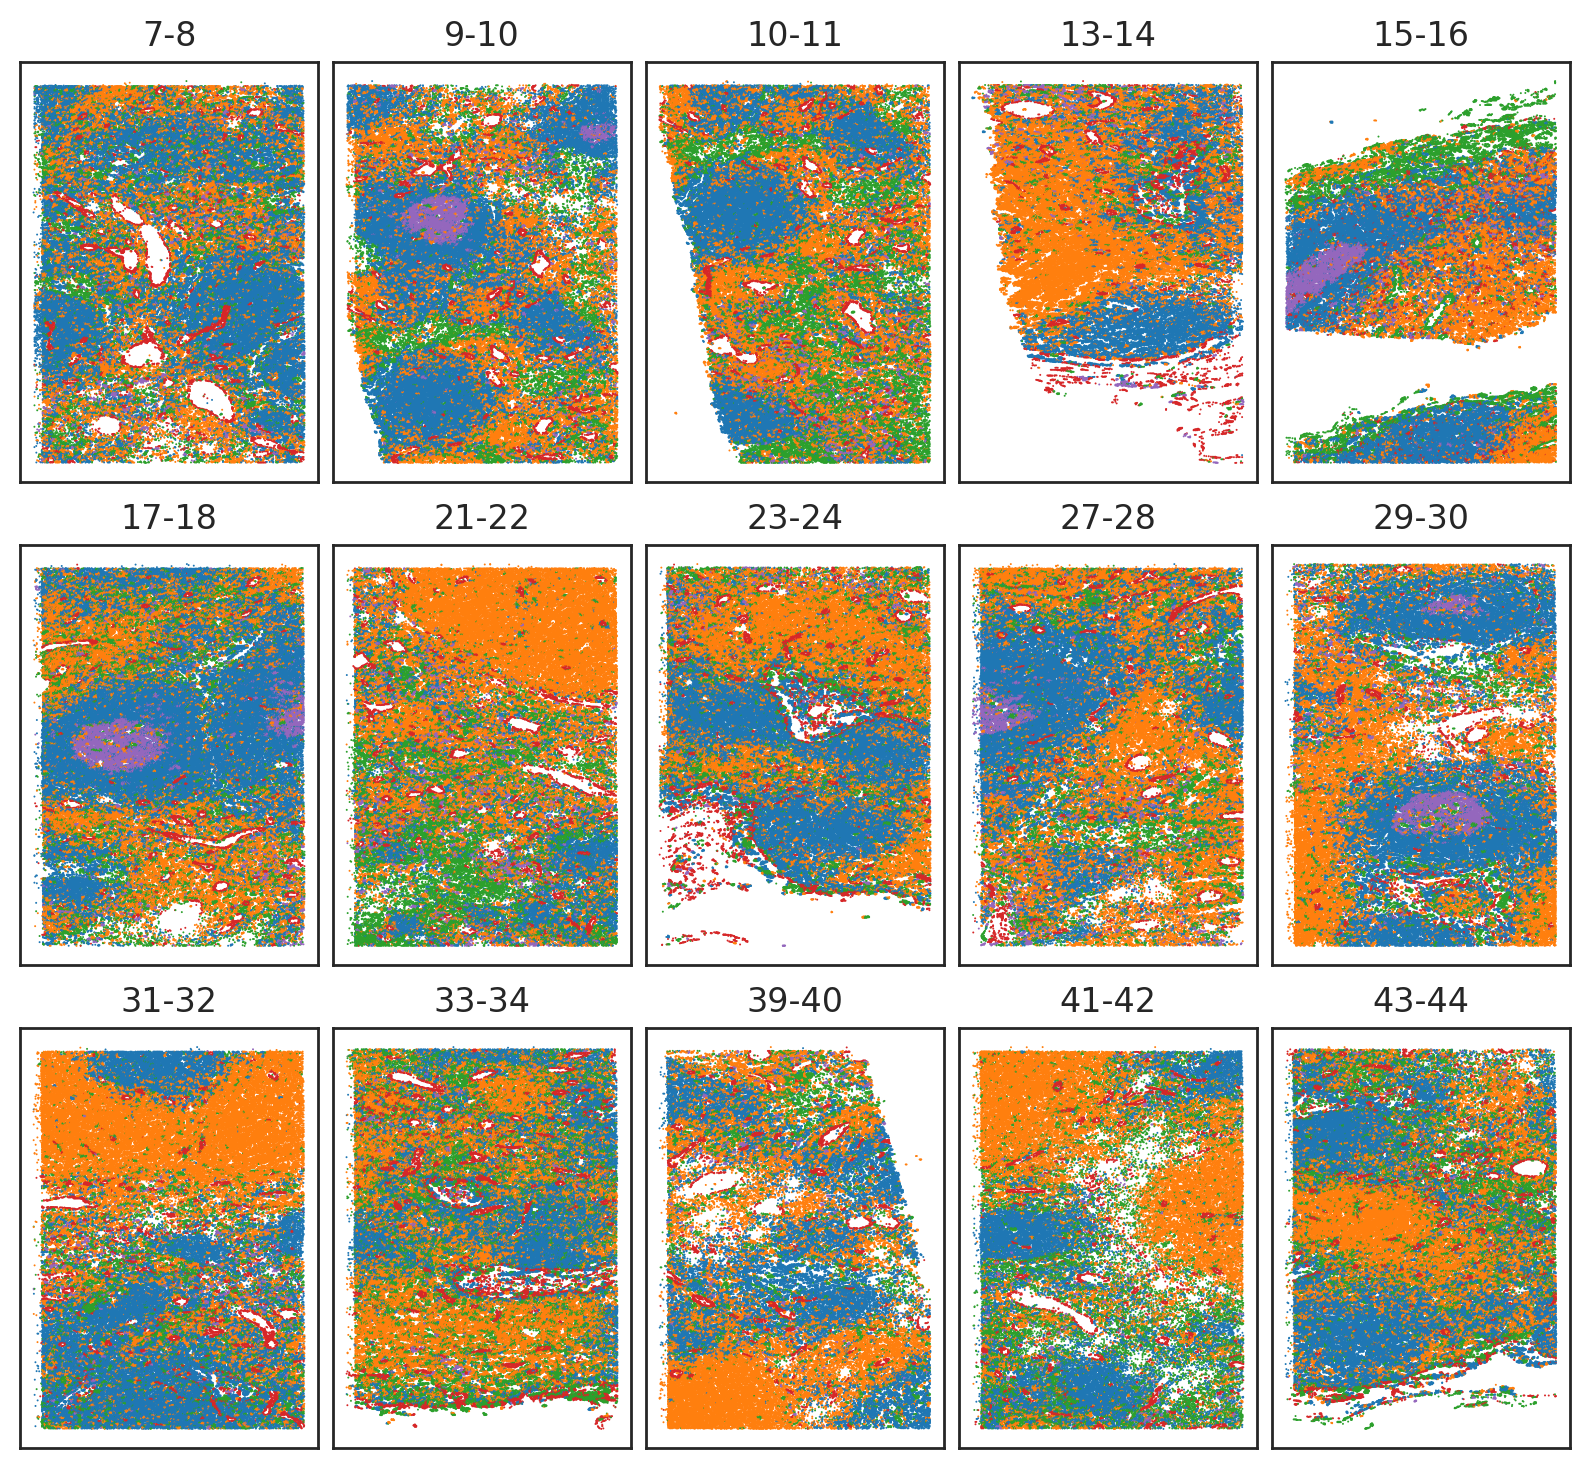

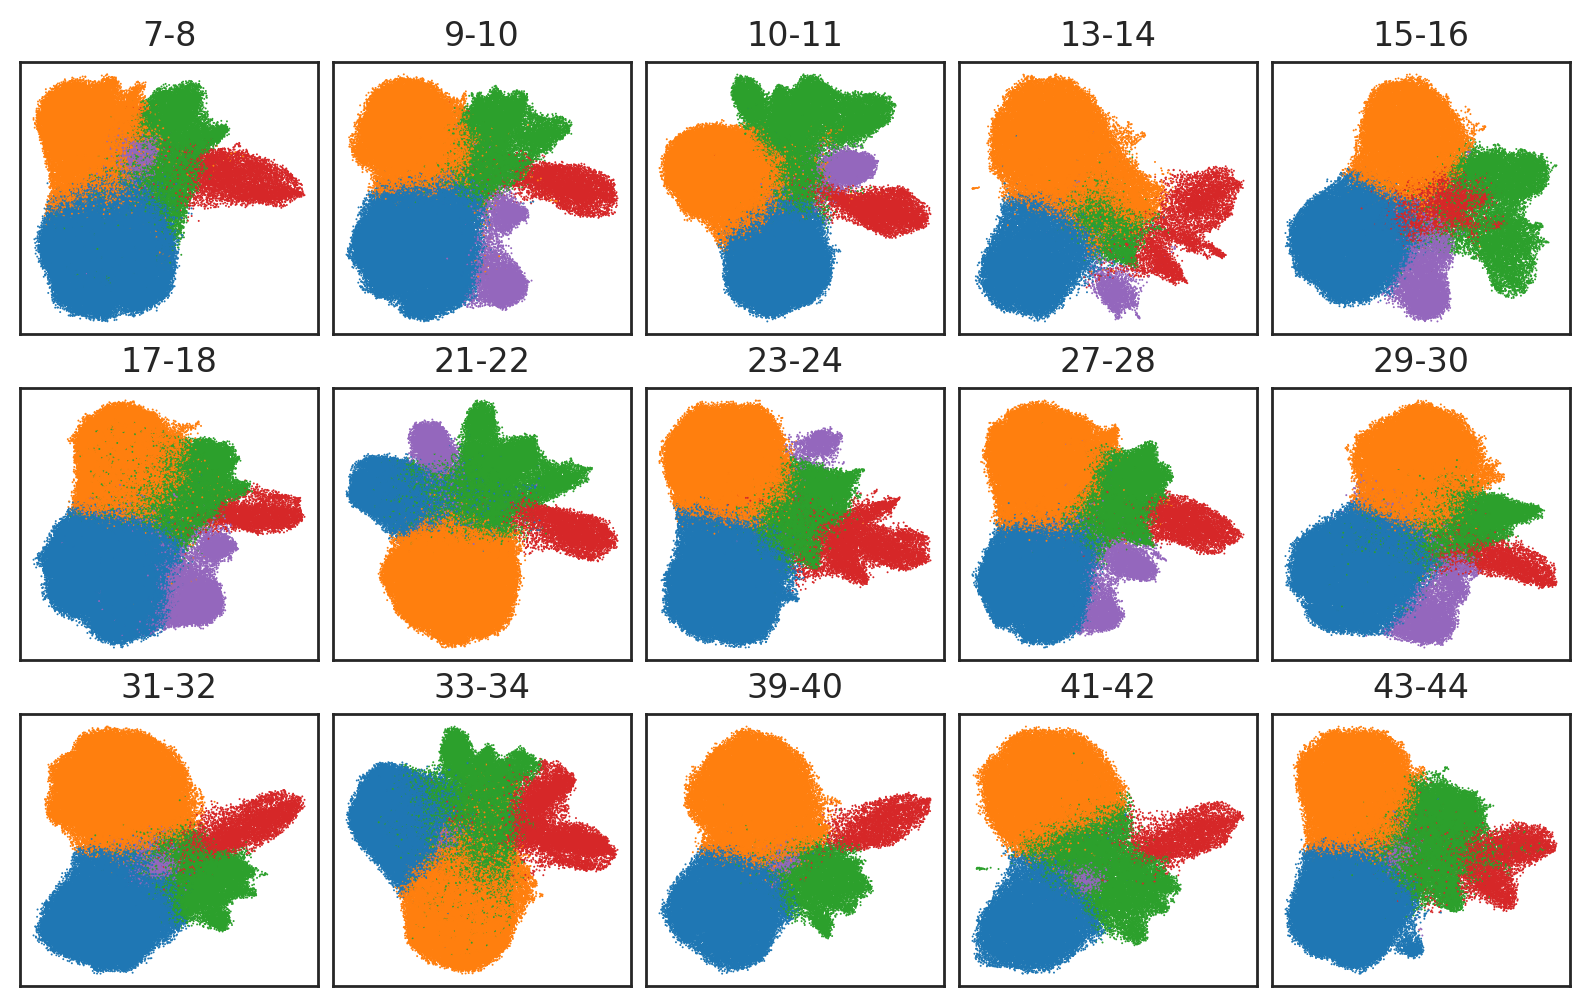

In [31]:
# Initialize figures
n_cols = 5
n_rows = int(np.ceil(len(fov_names) / n_cols))
# Spatial figure
fig1, axes1 = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 3), 
                           gridspec_kw={'wspace':0.05, 'hspace':0.15})
axes1 = axes1.flatten() 
# UMAP figure
fig2, axes2 = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2),
                           gridspec_kw={'wspace':0.05, 'hspace':0.2})
axes2 = axes2.flatten() 
# Loop through FOVs
for i, fov_name in enumerate(fov_names): 
    info = fov_cluster_info[fov_name]
    adata_path = f"{output_path}/{fov_name}/Glimmer/adata.h5ad"
    adata = sc.read_h5ad(adata_path)
    adata.obs['cell_type'] = (
        adata.obs[info["cluster_key"]]
        .astype(str)
        .map(info["mapping"])
    )
    adata = adata[~adata.obs['cell_type'].isna(), :]
    adata.obs['cell_type'] = pd.Categorical(adata.obs['cell_type'], categories=list(cell_type_colors.keys()))
    color_map = {ct: cell_type_colors[ct] for ct in adata.obs['cell_type'].unique() if ct in cell_type_colors}
    # Spatial plot
    sc.pl.embedding(adata, basis='spatial', color='cell_type', palette=color_map, s=2, 
                    title=fov_name, ax=axes1[i], show=False, legend_loc=None)
    axes1[i].set_xticks([])
    axes1[i].set_yticks([])
    axes1[i].set_xlabel("")
    axes1[i].set_ylabel("")
    # UMAP plot
    sc.pl.embedding(adata, basis='X_umap', color='cell_type', palette=color_map, s=2, 
                    title=fov_name, ax=axes2[i], show=False, legend_loc=None)
    axes2[i].set_xticks([])
    axes2[i].set_yticks([])
    axes2[i].set_xlabel("")
    axes2[i].set_ylabel("")
for j in range(i + 1, len(axes1)):
    fig1.delaxes(axes1[j])
    fig2.delaxes(axes2[j])
if save_fig:
    fig1_name = fig_path + 'figure4/fig4_s_xenium_Glimmer_all_FOVs_spatial_cluster.svg'
    fig1.savefig(fig1_name, format="svg", bbox_inches="tight")
    fig2_name = fig_path + 'figure4/fig4_s_xenium_Glimmer_all_FOVs_umap_cluster.svg'
    fig2.savefig(fig2_name, format="svg", bbox_inches="tight")
plt.show() 

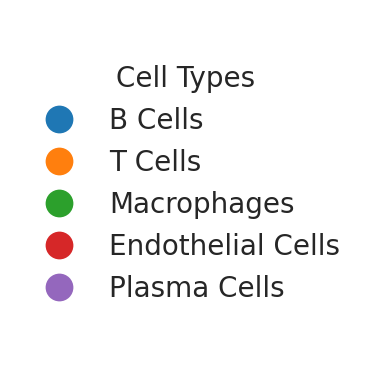

In [21]:
# Plot legend independently
legend_fig = plt.figure(figsize=(2, 2))
ax = legend_fig.add_subplot(111)
legend_elements = []
for cell_type, color in cell_type_colors.items():
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label=cell_type, markerfacecolor=color, markersize=11))
ax.legend(handles=legend_elements, loc='center', frameon=False, title='Cell Types', fontsize=10, title_fontsize=10)
ax.axis('off')
plt.tight_layout()
if save_fig:
    legend_fig_name = fig_path + 'figure4/fig4_s_xenium_Glimmer_cluster_legend.svg'
    legend_fig.savefig(legend_fig_name, format="svg", bbox_inches="tight")
plt.show()